# TAQ tick data

Concepts:

## Intraday liquidity                                                                                         
## Principal components                                                                                       
## Anomaly detection                                                                                          
## Supervised learning: regression, neural nets 

Author: Terence Lim

References:

-  Holden and Jacobsen (2014), "Liquidity Measurement" 

In [1]:
%matplotlib inline
import dives
import time, re, pickle
import numpy as np
import scipy as sp
import pandas as pd
import sklearn, sklearn.covariance, sklearn.ensemble, sklearn.neighbors, sklearn.svm
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  # for date formatting in plots                                             
from dives.util import DataFrame, NamedDict
from dives.dbengines import SQL, Redis
from dives.structured import BusDates, CRSP
from dives.taq import TAQ, plot_taq, measure_liquidity, clean_trade, clean_nbbo
from dives.custom import CustomRegressor, CustomScorer

import secret   # passwords, etc                                                                             
verbose = secret.value('verbose')
sql = SQL(**secret.value('sql'))
rdb = Redis(**secret.value('redis'))
bd = BusDates(sql)
crsp = CRSP(sql, bd, rdb)
taqdir = secret.value('taq')['dir']

pordate = 20171101   # daily taq files from ftp://ftp.nyxdata.com/Historical%20Data%20Samples/
master_file  = taqdir + 'EQY_US_ALL_REF_MASTER_{}.gz'.format(pordate)  # daily TAQ files                 
trade_file   = taqdir + 'EQY_US_ALL_TRADE_{}.gz'.format(pordate)
nbbo_file   = taqdir + 'EQY_US_ALL_NBBO_{}.gz'.format(pordate)

dives/__init__ : import dives ... [SUCCESS]


Using TensorFlow backend.


## My module parses daily TAQ into a dataframe; implements 3 different ways to access:

### 1. entire file (only do this for the smaller Master file)

In [2]:
    master = TAQ(master_file).read()
    print(master)

        Symbol                               Security_Description      CUSIP  \
A            A                               Agilent Technologies  00846U101   
AA          AA                                  Alcoa Corporation  013872106   
AAAP      AAAP  Advanced Accelerator Applications S.A. America...  00790T100   
AABA      AABA                           Altaba Inc. Common Stock  021346101   
AAC        AAC                                 AAC Holdings, Inc.  000307108   
...        ...                                                ...        ...   
ZXZZ T  ZXZZ T                                  SUPERMONTAGE TEST              
ZYME      ZYME                                     Zymeworks Inc.  98985W102   
ZYNE      ZYNE                       Zynerba Pharmaceuticals, Inc  98986X109   
ZZK        ZZK            NYSE Arca Listed Test Stock For CTS CQS              
ZZZ        ZZZ            NYSE Arca Listed Test Stock For CTS CQS              

       Security_Type SIP_Symbol Old_Sym

### 2. in sequential chunks, symbol by symbol, as an iterator

In [3]:
    trade = TAQ(trade_file).iter()
    df = next(trade)
    print('Read next Trade symbol {}, with {} records'.format(df.index.name, len(df)))
    df = next(trade)
    print('Read next Trade symbol {}, with {} records'.format(df.index.name, len(df)))

    nbbo = TAQ(nbbo_file).iter()
    df = next(nbbo)
    print('Read next Quote symbol {}, with {} records'.format(df.index.name, len(df)))
    df = next(nbbo)
    print('Read next Quote symbol {}, with {} records'.format(df.index.name, len(df)))


Read next Trade symbol A, with 11128 records
Read next Trade symbol AA, with 22464 records
Read next Quote symbol A, with 20554 records
Read next Quote symbol AA, with 33811 records


###  3. direct access, by symbol. but have to build indexes first, leveraging index_gzipped package

In [4]:
    nbbo_index  = taqdir + 'EQY_US_ALL_NBBO_20171101.gzidx'     # build and export these                     
    trade_index  = taqdir + 'EQY_US_ALL_TRADE_20171101.gzidx'

    nbbo_symbol = taqdir + 'EQY_US_ALL_NBBO_20171101.pkl'       # generate and save symbol positions         
    trade_symbol = taqdir + 'EQY_US_ALL_TRADE_20171101.pkl'

    trade = TAQ(trade_file)             # Trade file: build index and generate symbol positions              
    trade.create_index(trade_index)
    trade.create_symbols(trade_symbol)

    nbbo = TAQ(nbbo_file)               # NBBO file: build index and generate symbol positions               
    nbbo.create_symbols(nbbo_symbol)
    nbbo.create_index(nbbo_index)

### Now can retrieve by any symbol into a dataframe

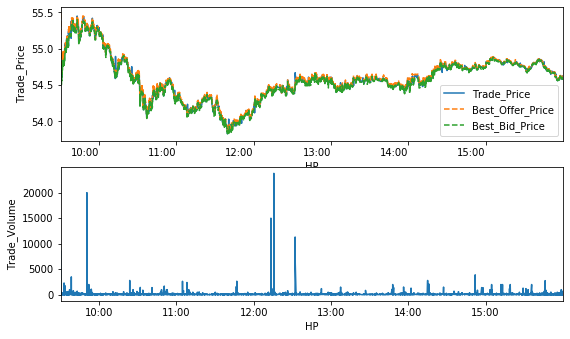

In [6]:
    Trade = TAQ(trade_file, trade_index)   # reset Trade file (with speedy index file)                       
    trade = Trade.open(trade_symbol)       #   and re-open for direct access (with symbol file)              
    Nbbo = TAQ(nbbo_file, nbbo_index)      # reset NBBO file (speedy index file)                             
    nbbo = Nbbo.open(nbbo_symbol)          #   and re-open for direct access (with symbol file)              

    symbol = 'HP'
    plot_taq(symbol, trade, nbbo)       # then directly retrieve, say 'HP', and plot  

### Other useful methods: clean trades and quotes; align and sign trades to derive liquidity metrics 

20171101 HP had 12874 trades, kept 12845
20171101 HP had 32343 nbbo quotes, kept 23071


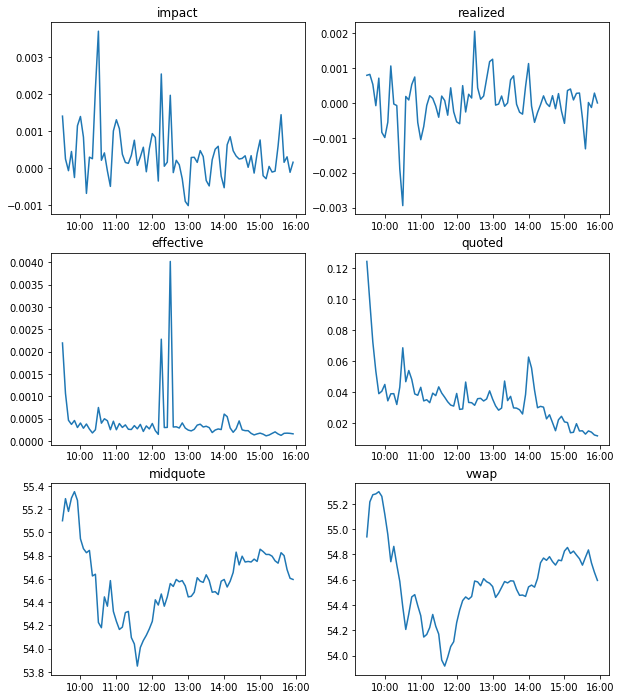

In [8]:
    t = trade.get(symbol)
    q = nbbo.get(symbol)
    ct = clean_trade(t)
    cq = clean_nbbo(q)
    print('{} {} had {} trades, kept {}'.format(pordate, symbol, len(t), len(ct)))
    print('{} {} had {} nbbo quotes, kept {}'.format(pordate, symbol, len(q), len(cq)))
    
    df = measure_liquidity(ct, cq, minutes=5)  # liquidity metrics summarized at 5-minute intervals          
    measures = ['impact','realized','effective','quoted', 'midquote', 'vwap']
    plt.figure(figsize=(10, 12))
    for i in range(len(measures)):
        plt.subplot(3,2,i+1)
        ax = plt.gca()
        sns.lineplot(data=df[measures[i]])
        plt.title(measures[i])
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


## Cross-sectional analysis of intraday liquidity
### Compute 5-minute liquidity metrics for all stocks

In [10]:
    # get usual universe of stocks from CRSP as of prior day, and keep their 8-character cusip               
    pordate = bd.shift(20171101, -1)
    univ = crsp.get_universe(pordate)
    univ = univ[univ['cap'] > 300000]
    ncusip = crsp.get_section('names',['ncusip','exchcd'],'date',pordate,0).drop_duplicates('ncusip')
    univ = univ.join(ncusip, how='inner').reset_index().set_index('ncusip')

    # loop over each stock in universe, and extract and compute 5-minute liquidity metrics                   
    cache = dict()
    toc = time.time()
    univ['symbol'] = ''
    for symbol, header in master.iterrows():
        if header['CUSIP'][:8] in univ.index:
            tic = time.time()
            t = trade.get(symbol)
            q = nbbo.get(symbol)
            ct = clean_trade(t)
            cq = clean_nbbo(q)
            if ct is not None and cq is not None and len(ct) and len(cq):
                df = measure_liquidity(ct, cq, minutes=5)
                cache[symbol] = df
                univ.loc[univ.index == header['CUSIP'][:8], 'symbol'] = symbol
                #print(symbol, len(df), len(t), len(ct), len(q), len(cq),
                #      time.time() - tic, len(cache), time.time()-toc)
    univ = univ.set_index('symbol', drop=False)
    univ = univ[~univ.index.duplicated()].reindex(list(cache.keys()))
    print('{} symbols summarized, in {} secs'.format(len(cache), time.time() - tic))


2338 symbols summarized, in 0.8975825309753418 secs


In [11]:
    measures = ['impact','realized','effective','quoted', 'depth','vwap', 'midquote','volume']
    derived = ['relquoted', 'relmidquote', 'relvwap', 'reldepth', 'turnover']
    liquidity = {measure : DataFrame() for measure in measures + derived}
    for symbol in cache:
        if univ.loc[symbol, 'cap'] >= 300000: #2000000:                                                      
            df = cache[symbol][measures].copy()
            df['relquoted']   = df['quoted']   / df['midquote']     # df['midquote'].mean() #                
            df['relmidquote'] = df['midquote'] / df['midquote'][0]  # df['midquote'].mean() #                
            df['relvwap']     = df['vwap']     / df['vwap'][0]
            df['reldepth']    = df['depth']    / df['depth'].mean()
            df['turnover']    = df['volume']   / df['volume'].sum()
            if not np.isnan(df.iloc[1:-1]).any().any():   # screen out illiquid stocks                       
                for measure in liquidity.keys():
                    liquidity[measure][symbol] = df[measure]


### PCA/SVD to extract systematic/common components of intraday liquidity
    With (5-minute) time periods as row samples, and (1600+) stocks in columns,                              
    an SVD decomposition U s Vh yields:                                                                      
    columns of U are time series vectors -- the first is just the average time trend                         
    the values in the i'th column of Vh are the respective stocks' loadings on the i'th eigenvector          
    and each ith value in diagonal s is the square root of the variance explained by the i'th eigenvector

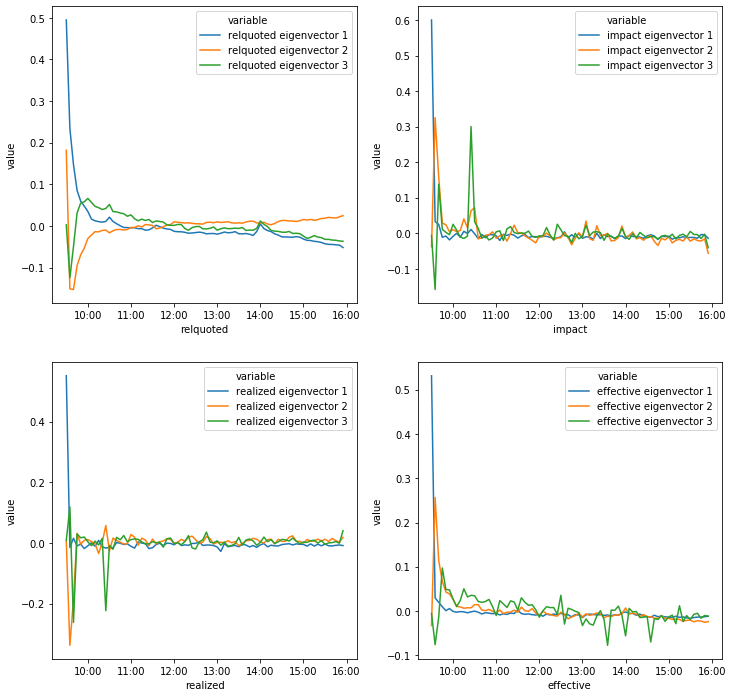

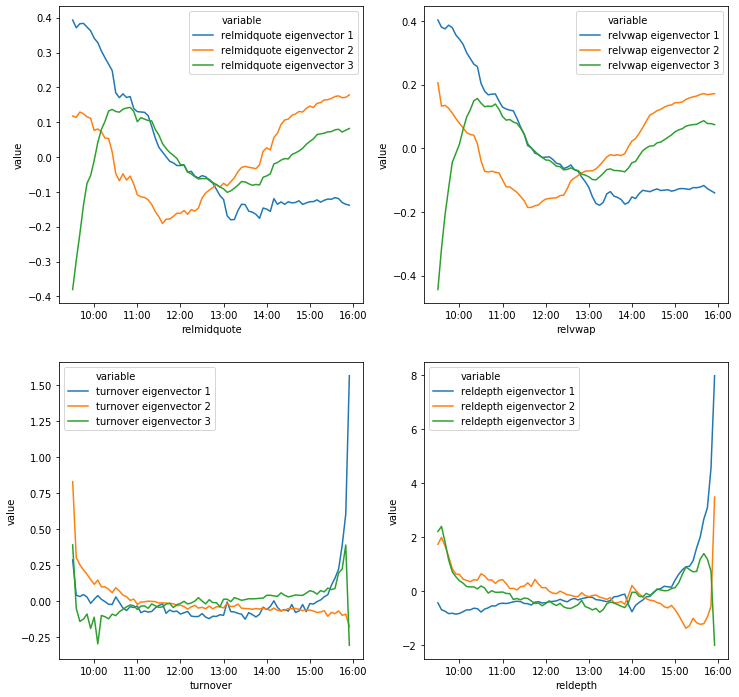

In [16]:
    for ifig, measures in enumerate([['relquoted', 'impact','realized', 'effective'],
                                     ['relmidquote','relvwap','turnover','reldepth']]):
        plt.figure(ifig + 1, figsize=(12,12))
        for iplot, measure in enumerate(measures):
            ax = plt.subplot(2, 2, iplot + 1)
            trend = liquidity[measure].mean(axis = 1)  # average trend = first eigenvector (except sign)     
            X = liquidity[measure]
            X = X - X.mean(axis=0)
            U, s, Vh = sp.linalg.svd(X, full_matrices=False)
            k = 3
            d = DataFrame(U[:,:k]*np.sqrt(s[:k]),      # put vectors of interest into wide dataframe         
                          columns = ['{} eigenvector {}'.format(measure, i+1) for i in range(k)],
                          index = X.index)
            sgn = np.sign(d.apply(lambda x: np.corrcoef(x, trend)[0,1]))  # direction of eigenvector         
            sns.lineplot(x ='index',                                      # standard template for            
                         y = 'value',                                     #   sns multi-line plot            
                         hue = 'variable',
                         data = pd.melt((d*sgn).reset_index(), ['index']))   # align with sign of trend      
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            plt.xlabel(measure)


### For each metric: how much do systematic components explain cross-sectional liquidity

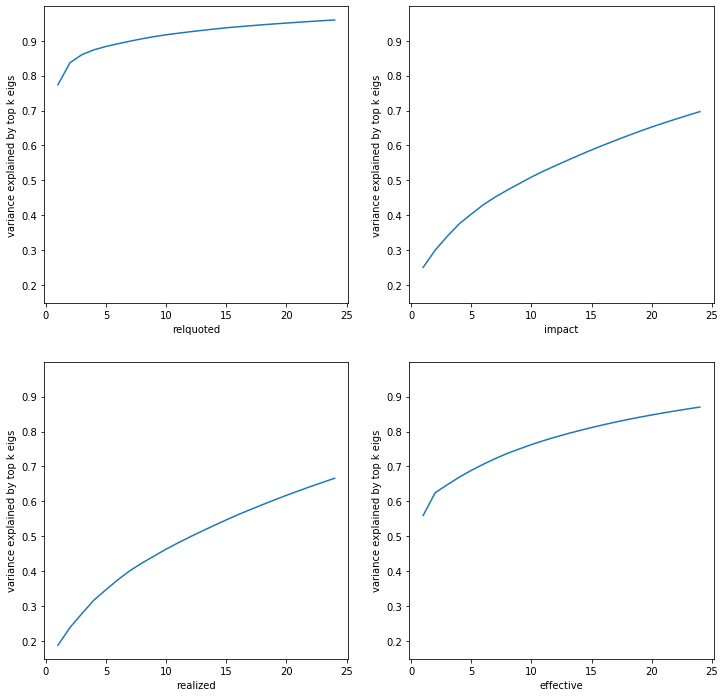

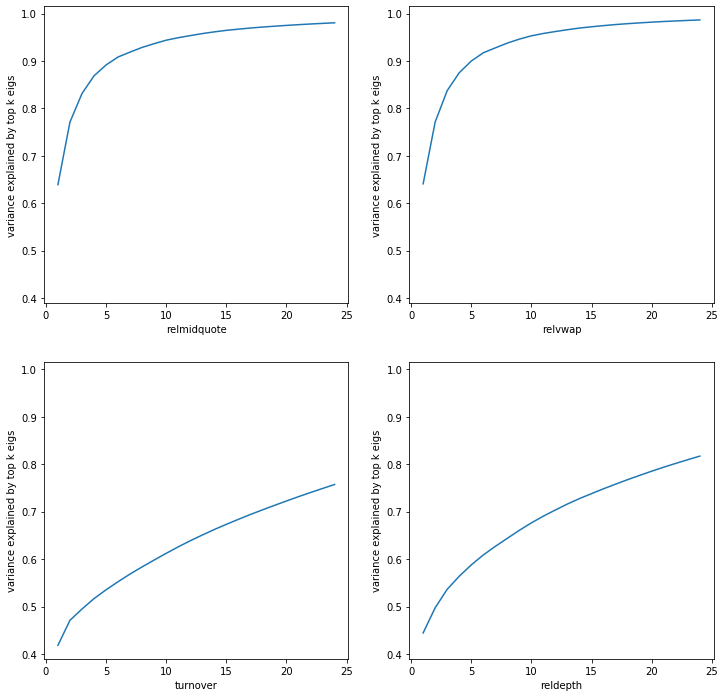

In [17]:
    for ifig, measures in enumerate([['relquoted', 'impact','realized', 'effective'],
                                     ['relmidquote','relvwap','turnover','reldepth']]):
        plt.figure(ifig + 1, figsize=(12,12))
        ax = plt.subplot(2,2,1)   # get ax of first subplot, to be shared by other subplots                  
        for iplot, measure in enumerate(measures):
            X = liquidity[measure]  #.iloc[1:-1]   # ignore first and last five minute interval              
            X = X - X.mean(axis=0)
            U, s, Vh = sp.linalg.svd(X, full_matrices=False)
            explained = [sum(s[:k]**2)/sum(s**2) for k in range(1, 25)]
            plt.subplot(2, 2, iplot + 1, sharex=ax, sharey=ax)
            sns.lineplot(y=explained, x=np.arange(1, len(explained)+1))
            plt.xlabel(measure)
            plt.ylabel('variance explained by top k eigs')


### Brief digression on SVD and linear regression
Each i'th column of Vh are loadings, or stocks' coefficients on the i'th eigenvector                     
from a linear (time-series) regression with all the eigenvectors as explanatory variables                
Hence the (square of the) eigenvalues and incremental regression R2 are equal.                           
We can think of representing the stocks in reduced two dimensions, by plotting them by their            
loadings on the first two eigenvectors (which explains most of the variation across stocks)

In [18]:
    measure = 'turnover'
    df = liquidity[measure].iloc[1:-1]
    X = np.array(df - df.mean(axis=0))

    # For plotting in 2-dimensional space, reduce data by PCA                                                
    U, s, Vh = sp.linalg.svd(X, full_matrices=False)
    sst = np.mean(np.mean(X**2))
    for k in range(5):
        fitted = (s[:k] * U[:, :k]).dot(Vh[:k, :]) # Vh column * sqrt(s) is loadings on U column eigenvector
        sse = np.mean(np.mean((X - fitted)**2))    # unexplained variance (= 1 - R2)                         
        print(k, np.round(1-(sse/sst), 4), np.round(sum(s[:k]**2)/sum(s**2), 4))  # compare eigenvalues^2    


0 0.0 0.0
1 0.1887 0.1887
2 0.2428 0.2428
3 0.2722 0.2722
4 0.299 0.299


### Anomaly detection of turnover 
see [sklearn example](https://scikit-lehttps://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.htmlarn.org/stable/auto_examples/plot_anomaly_comparison.html)

Robust covariance ['ATRA', 'ATUS', 'GLBL', 'PDLI', 'WAGE']
One-Class SVM ['ATKR', 'ATRA', 'ATUS', 'PDLI']
Isolation Forest ['ABCO', 'ETM', 'USAT', 'VSLR', 'XCRA']
Local Outlier Factor ['ATKR', 'ATRA', 'ATUS', 'ELF', 'PDLI']


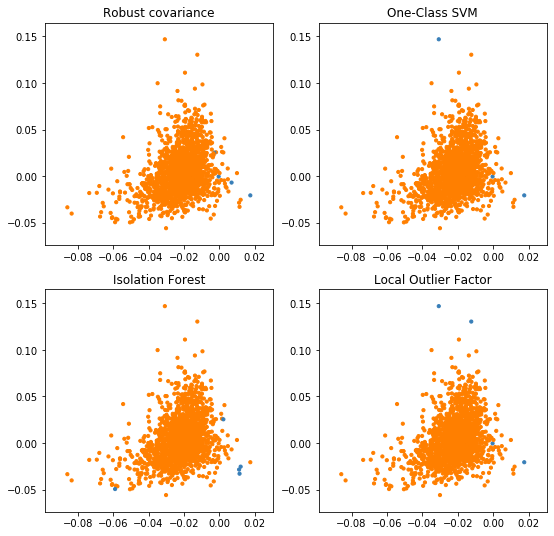

In [19]:
    # define four outlier/anomaly detection methods to be compared                                           
    y = X.T         # sample rows should now be stocks, feature columns are now the time intervals           
    x = Vh[:2,:].T  # use stocks' loadings on top two components for (imperfect) 2D scatter plots            
    outliers_fraction = 5/y.shape[0]  # set fraction to extract 5 anomalies                                  
    anomaly_algorithms = [
        ("Robust covariance",
         sklearn.covariance.EllipticEnvelope(contamination = outliers_fraction)),
        ("One-Class SVM",
         sklearn.svm.OneClassSVM(nu = outliers_fraction, kernel = "rbf", gamma = 0.1)),
        ("Isolation Forest",
         sklearn.ensemble.IsolationForest(contamination = outliers_fraction, random_state = 42)),
        ("Local Outlier Factor",
         sklearn.neighbors.LocalOutlierFactor(n_neighbors = 35, contamination = outliers_fraction))]

    # spot the detected stocks in two-dimensional space -- the algos picked different stocks                 
    plt.figure(1, figsize=(9,9))
    ax = plt.subplot(2, 2, 1)
    symbols = set()   # to collect stock symbols of detected outliers                                        
    for iplot, (name, algorithm) in enumerate(anomaly_algorithms):
        name, algorithm = anomaly_algorithms[iplot]

        # fit the data and tag outliers                                                                      
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(y)
        else:
            y_pred = algorithm.fit(y).predict(y)

        plt.subplot(2, 2, iplot+1, sharex=ax, sharey=ax)
        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(Vh[0, :], Vh[1, :], s=10, color=colors[(y_pred + 1) // 2])
        plt.title(name)   # todo: label symbol                                                               

        print(name, list(df.columns[y_pred < 0]))
        symbols = symbols.union(df.columns[y_pred < 0])

### Show underlying trades of the anomalous stocks identified

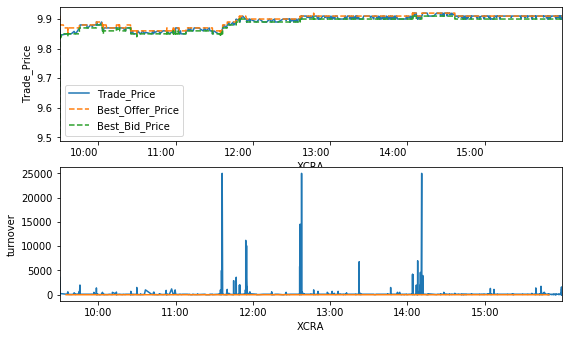

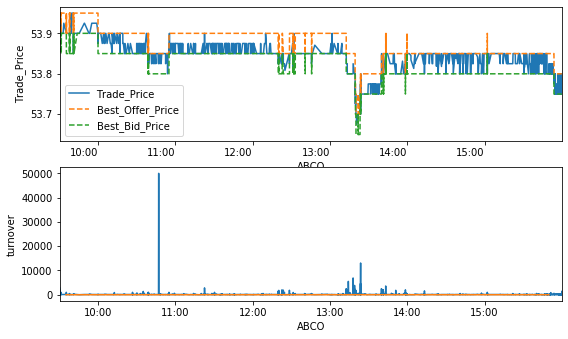

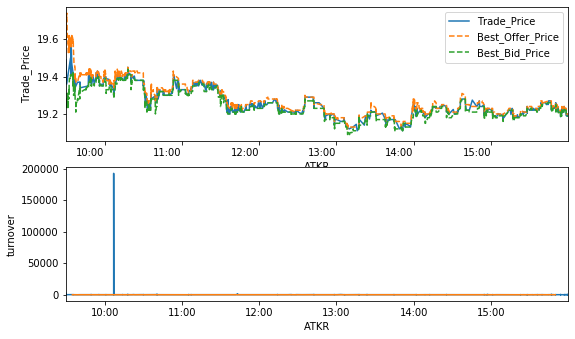

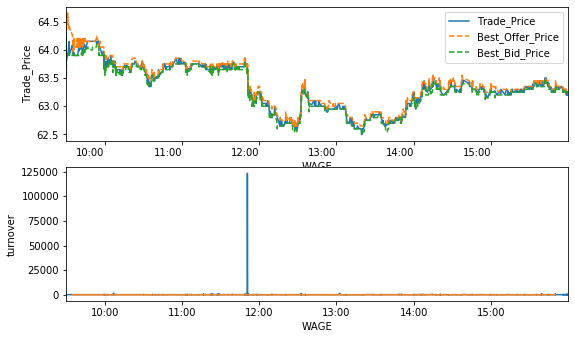

In [20]:
    for ifig, symbol in enumerate(np.random.choice(list(symbols), 4, replace = False)):
        plot_taq(symbol, trade, nbbo)

        ax = plt.gca()
        plt.plot(df.index, X[:, np.where(df.columns == symbol)[0][0]])
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        plt.ylabel(measure)
        plt.xlabel(symbol)

### Supervised Learning:                                                                                  
Predict last hour (3:00pm-3:55pm) of trading turnover from earlier (9:35am-3:00pm) intraday liquidity patterns (5-minute intervals)

KeyboardInterrupt: 

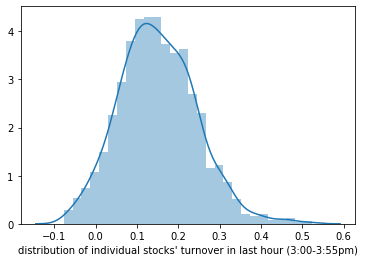

In [23]:
    # construct y_all = turnover after 3pm less mean before 3pm                                              
    y_all = (liquidity['turnover'].iloc[66:]-liquidity['turnover'].iloc[:66].mean(axis=0)).sum(axis=0)
    sns.distplot(y_all, axlabel="distribution of individual stocks' turnover in last hour (3:00-3:55pm)")

    # features include turnover, midquote, relquoted in the 5-minute intervals before 3:00pm                 
    # as the respective first 20 eigenvectors                                                                
    X_all = DataFrame()
    for measure in ['turnover', 'midquote', 'relquoted']:
        df = liquidity[measure].iloc[1:66]
        X = np.array(df - df.mean(axis=0))
        U, s, Vh = sp.linalg.svd(X, full_matrices=False)
        topK = 20
        eigen_features = [measure + str(c+1) for c in range(len(Vh))]
        time_features = [measure[0] + str(c) for c in range(len(X))]
        X_all = pd.concat([DataFrame(data=X.T, columns = time_features, index=df.columns),
                           DataFrame(data=Vh[:topK, :].T, columns=eigen_features[:topK],
                                     index=df.columns),
                           X_all], axis=1)
    X_all = X_all.reindex(y_all.index)

    # use stratified 3-fold cross-validation to estimate "test" error                                        
    out = NamedDict(['name','split'])
    for name in CustomRegressor.keys():    # for all regression methods                                      
        clf = CustomRegressor[name]
        results = sklearn.model_selection.cross_validate(
            clf, X_all, y_all, verbose=0,
            return_train_score=True,
            return_estimator=True,
            scoring = {s : CustomScorer(s) for s in ['r2', 'spearman']},
            cv = sklearn.model_selection.KFold(3, shuffle=True, random_state=42))
        out.replace(name = name,           # record the average training set error in cross_validation       
                    split = 'train',
                    elapsed = results['fit_time'].mean(),
                    r2 = results['train_r2'].mean(),
                    spearman = results['train_spearman'].mean())
        out.replace(name = name,           # record the average validation set error in cross_validation     
                    split = 'test',
                    elapsed = results['score_time'].mean(),
                    r2 = results['test_r2'].mean(),
                    spearman = results['test_spearman'].mean())
        #pprint(out)

    # only for illustrating regularization and generalization trade-offs of the models                       
    sns.catplot(x='split', y='r2', hue='name', data=DataFrame(out.search()), kind='bar')
